In [ ]:
# ====== BLOCO 1: Importação e leitura dos dados ======
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = pd.read_csv("../database/personalized_learning_dataset.csv")

# Visualizar as primeiras linhas
df.head()

,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No


In [ ]:
# ====== BLOCO 2: Criar variável binária para evasão ======
print("Valores únicos em Dropout_Likelihood:", df['Dropout_Likelihood'].unique())
df['Evadiu'] = df['Dropout_Likelihood'].map({'No': 0, 'Yes': 1})

Valores únicos em Dropout_Likelihood: ['No' 'Yes']


In [ ]:
# ====== BLOCO 3: Criar variáveis comportamentais derivadas ======

# Exemplo para criação de variáveis comportamentais derivadas

# Converter colunas para datetime (se existirem)
if 'login_timestamp' in df.columns:
    df['login_timestamp'] = pd.to_datetime(df['login_timestamp'])
if 'assignment_due_date' in df.columns:
    df['assignment_due_date'] = pd.to_datetime(df['assignment_due_date'])
if 'assignment_submission_date' in df.columns:
    df['assignment_submission_date'] = pd.to_datetime(df['assignment_submission_date'])

# 1) Login_Frequency: média de logins por semana por aluno
if 'login_timestamp' in df.columns and 'student_id' in df.columns:
    df['Week'] = df['login_timestamp'].dt.isocalendar().week
    login_freq = df.groupby(['student_id', 'Week']).size().groupby('student_id').mean()
    df = df.merge(login_freq.rename('Login_Frequency'), on='student_id', how='left')

# 2) Average_Session_Duration: média de duração das sessões
if 'session_duration' in df.columns and 'student_id' in df.columns:
    avg_session = df.groupby('student_id')['session_duration'].mean()
    df = df.merge(avg_session.rename('Average_Session_Duration'), on='student_id', how='left')

# 3) Forum_Posts_Count: total de posts por aluno
if 'forum_posts' in df.columns and 'student_id' in df.columns:
    forum_posts = df.groupby('student_id')['forum_posts'].sum()
    df = df.merge(forum_posts.rename('Forum_Posts_Count'), on='student_id', how='left')

# 4) Assignment_Submission_Timeliness: atraso médio em dias
if ('assignment_due_date' in df.columns and
    'assignment_submission_date' in df.columns and
    'student_id' in df.columns):
    df['submission_delay'] = (df['assignment_submission_date'] - df['assignment_due_date']).dt.days
    avg_delay = df.groupby('student_id')['submission_delay'].mean()
    df = df.merge(avg_delay.rename('Assignment_Submission_Timeliness'), on='student_id', how='left')

# 5) Tutor_Interactions: número de contatos
if 'tutor_contacts' in df.columns and 'student_id' in df.columns:
    tutor_contacts = df.groupby('student_id')['tutor_contacts'].sum()
    df = df.merge(tutor_contacts.rename('Tutor_Interactions'), on='student_id', how='left')

# 6) Video_Completion_Rate: média percentual de vídeos assistidos até o fim
if 'video_watch_percent' in df.columns and 'student_id' in df.columns:
    video_completion = df.groupby('student_id')['video_watch_percent'].mean()
    df = df.merge(video_completion.rename('Video_Completion_Rate'), on='student_id', how='left')

# Remover colunas temporárias
if 'Week' in df.columns:
    df.drop(columns=['Week'], inplace=True)
if 'submission_delay' in df.columns:
    df.drop(columns=['submission_delay'], inplace=True)

In [ ]:
# ====== BLOCO 4: Visualização das variáveis comportamentais vs evasão ======

novas_vars = ['Login_Frequency', 'Average_Session_Duration', 'Forum_Posts_Count',
              'Assignment_Submission_Timeliness', 'Tutor_Interactions', 'Video_Completion_Rate']

for var in novas_vars:
    if var in df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='Evadiu', y=var, data=df)
        plt.title(f'{var} vs Evasão')
        plt.xlabel('Evasão')
        plt.ylabel(var)
        plt.xticks([0, 1], ['Não Evadiu', 'Evadiu'])
        plt.tight_layout()
        plt.show()

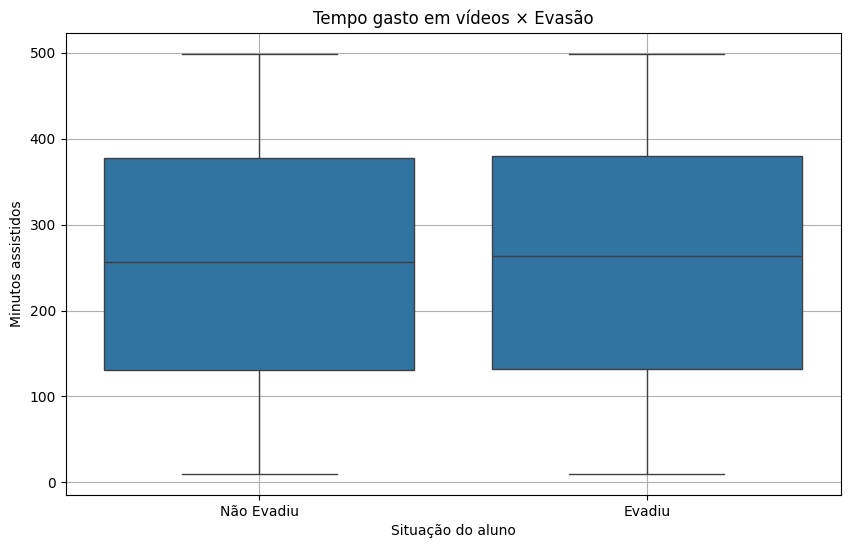

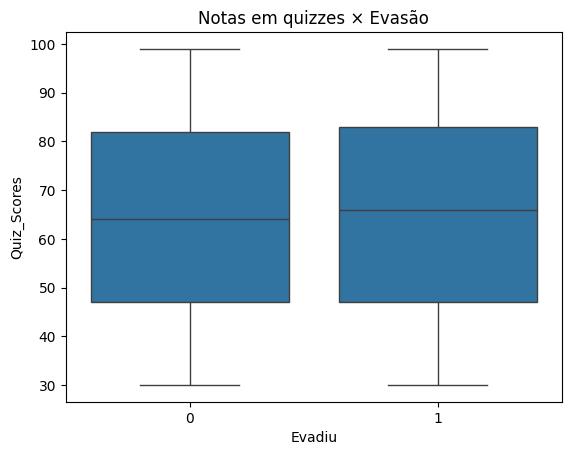

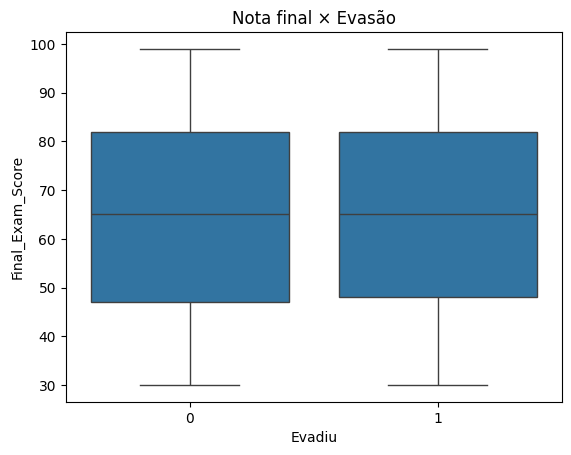

In [ ]:
# ====== BLOCO 5: Análises que você já tinha (exemplo com vídeos e quizzes) ======

plt.figure(figsize=(10,6))
sns.boxplot(x='Evadiu', y='Time_Spent_on_Videos', data=df)
plt.xticks([0,1], ['Não Evadiu', 'Evadiu'])
plt.title('Tempo gasto em vídeos × Evasão')
plt.xlabel('Situação do aluno')
plt.ylabel('Minutos assistidos')
plt.grid(True)
plt.show()

sns.boxplot(x='Evadiu', y='Quiz_Scores', data=df)
plt.title('Notas em quizzes × Evasão')
plt.show()

sns.boxplot(x='Evadiu', y='Final_Exam_Score', data=df)
plt.title('Nota final × Evasão')
plt.show()

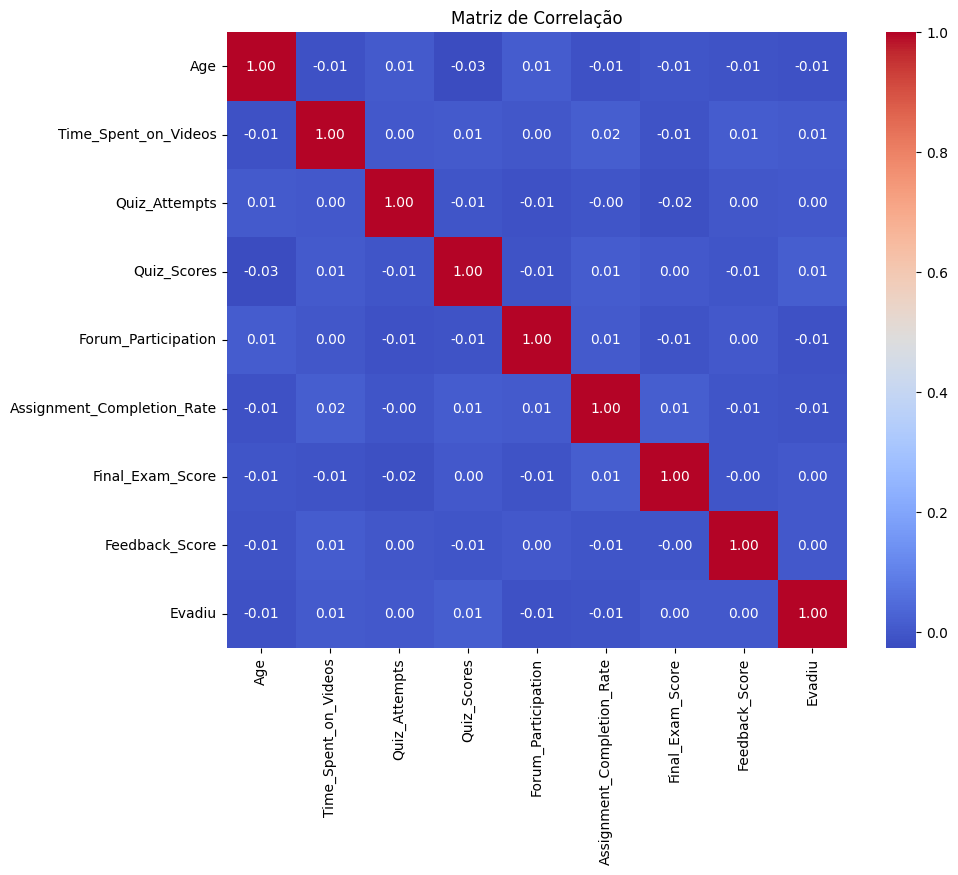

In [ ]:
# ====== BLOCO 6: Matriz de correlação das variáveis numéricas ======

numericas = df.select_dtypes(include='number')

plt.figure(figsize=(10,8))
sns.heatmap(numericas.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
# ====== BLOCO 7: Clusterização incluindo as novas variáveis ======

# Definir variáveis para clusterização
cluster_vars = [
    'Time_Spent_on_Videos',
    'Quiz_Scores',
    'Feedback_Score',
    'Final_Exam_Score',
    'Assignment_Completion_Rate',
    'Forum_Participation',
]

# Adiciona as novas variáveis, se existirem no df
for var in novas_vars:
    if var in df.columns:
        cluster_vars.append(var)

# Remover linhas com dados faltantes nas variáveis selecionadas
df_cluster = df[cluster_vars + ['Evadiu']].dropna().copy()

# Normalizar variáveis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[cluster_vars])

In [ ]:
# ====== BLOCO 8: Aplicar KMeans ======

kmeans = KMeans(n_clusters=5, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

display(df_cluster['Cluster'].value_counts().sort_index())

media_clusters = df_cluster.groupby('Cluster')[cluster_vars].mean().round(2)
display(media_clusters.style.background_gradient(cmap='YlGnBu'))

,count
Cluster,
0,1865
1,2053
2,1958
3,1992
4,2132


,Time_Spent_on_Videos,Quiz_Scores,Feedback_Score,Final_Exam_Score,Assignment_Completion_Rate,Forum_Participation
Cluster,,,,,,
0,352.630000,66.120000,1.930000,71.110000,70.330000,11.980000
1,107.550000,61.590000,3.040000,81.750000,70.110000,23.700000
2,365.660000,65.920000,3.800000,75.930000,70.570000,36.230000
3,213.390000,65.960000,1.850000,47.650000,70.760000,33.780000
4,250.600000,63.580000,4.290000,48.270000,66.250000,17.330000


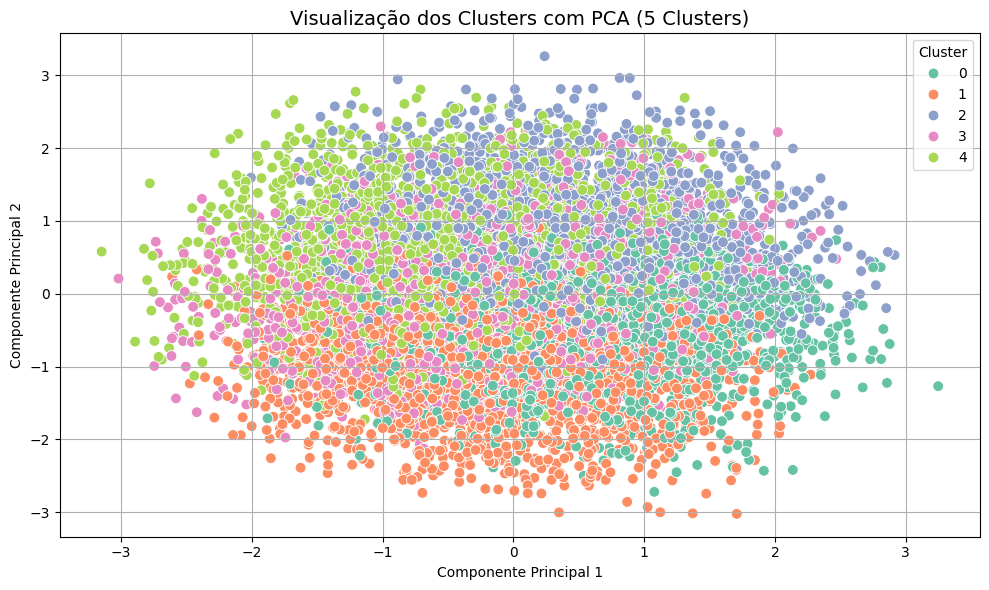

In [ ]:
# ====== BLOCO 9: Visualizar clusters com PCA ======

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_cluster['Cluster'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
plt.title('Visualização dos Clusters com PCA (5 Clusters)', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ====== BLOCO 10: Avaliar evasão por cluster ======

evasao_por_cluster = df_cluster.groupby('Cluster')['Evadiu'].mean()
distribuicao = df_cluster.groupby('Cluster')['Evadiu'].value_counts(normalize=True).unstack()

print("Taxa média de evasão por cluster:")
print(evasao_por_cluster)

print("\nDistribuição proporcional de evasão (0=Não,1=Sim) por cluster:")
print(distribuicao)

Taxa média de evasão por cluster:
Cluster
0    0.210724
1    0.198734
2    0.194586
3    0.188755
4    0.187148
Name: Evadiu, dtype: float64

Distribuição proporcional de evasão (0=Não,1=Sim) por cluster:
Evadiu          0         1
Cluster                    
0        0.789276  0.210724
1        0.801266  0.198734
2        0.805414  0.194586
3        0.811245  0.188755
4        0.812852  0.187148
